# Financial Time Series Prediction with Transformer Model
---

## Import Libraries

In [70]:
!pip install ta

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29423 sha256=e1d32b699f4571cf035abf067b718d67444f3496cf87aab5212f013d0c743a7d
  Stored in directory: c:\users\mehur\appdata\local\pip\cache\wheels\5f\67\4f\8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error

from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy
import ta

In [7]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Preparation

In [8]:
# Parameters
ticker = "^GSPC"  # S&P 500
start_date = "1980-01-01"
end_date = "2024-01-01"
sequence_length = 64  # Number of days to use for prediction
train_ratio = 0.7  # Train split ratio
val_ratio = 0.15  # Validation split ratio
test_ratio = 0.15  # Test split ratio

In [9]:
import yfinance as yf
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

def load_financial_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError("No data fetched. Check your ticker or date range.")
    prices = data['Close'].pct_change().dropna().values  # Calculate percentage change and drop NaN
    volume = data['Volume'].values[1:]  # Adjust volume to match the length of the prices after pct_change
    dates = data.index[1:]  # Adjust dates to match the length of the prices after pct_change
    return prices, volume, dates

def preprocess_data(prices, volume, sequence_length, train_ratio=0.7, val_ratio=0.15):
    if len(prices) == 0 or len(volume) == 0:
        raise ValueError("No data available to process.")

    # Stack percentage changes of prices and volume as features
    data = np.column_stack((prices, volume))
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(data)

    # Create sequences
    input_sequences = []
    output_sequences = []
    for i in range(len(normalized_data) - sequence_length):
        input_sequences.append(normalized_data[i:i + sequence_length])
        output_sequences.append(normalized_data[i + sequence_length, 0])  # Predicting the next price change

    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    # Split into train, val, and test sets
    total_size = len(input_sequences)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size

    train_inputs = input_sequences[:train_size]
    train_outputs = output_sequences[:train_size]
    val_inputs = input_sequences[train_size:train_size + val_size]
    val_outputs = output_sequences[train_size:train_size + val_size]
    test_inputs = input_sequences[train_size + val_size:]
    test_outputs = output_sequences[train_size + val_size:]

    # Convert to PyTorch tensors and move to the selected device
    train_inputs = torch.from_numpy(train_inputs).float().to(device)
    train_outputs = torch.from_numpy(train_outputs).float().to(device)
    val_inputs = torch.from_numpy(val_inputs).float().to(device)
    val_outputs = torch.from_numpy(val_outputs).float().to(device)
    test_inputs = torch.from_numpy(test_inputs).float().to(device)
    test_outputs = torch.from_numpy(test_outputs).float().to(device)

    return train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, scaler

In [10]:
# Load and preprocess data 
prices, volume, dates = load_financial_data(ticker, start_date, end_date)
train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, scaler = preprocess_data(prices, volume, sequence_length, train_ratio, val_ratio)

[*********************100%***********************]  1 of 1 completed


---

## Model Definition

In [57]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).to(device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1).to(device)
        div_term = torch.exp(torch.arange(0, d_model, 2).float().to(device) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term)[:,:-1]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim=2, d_model=64, nhead=4, num_layers=1, dim_feedforward=256, dropout=0.5):
        super(TransformerTimeSeries, self).__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        # src shape: (batch_size, seq_len, input_dim)
        src = self.input_projection(src)  # (batch_size, seq_len, d_model)
        src = self.positional_encoding(src)  # Add positional encoding
        src = src.permute(1, 0, 2)  # (seq_len, batch_size, d_model)
        output = self.transformer_encoder(src)
        output = output[-1, :, :]  # Use the output from the last time step
        output = self.decoder(output)
        return output.squeeze()


---

## Training the Model

In [58]:
def custom_loss(outputs, targets):
    epsilon = 1e-8
    # Compute percentage changes using tensor slicing (do not detach)
    pred_pct_change = (outputs[1:] - outputs[:-1]) / (targets[:-1] + epsilon) * 100
    actual_pct_change = (targets[1:] - targets[:-1]) / (targets[:-1] + epsilon) * 100

    # Mean Squared Error for raw prices
    mse_price = nn.MSELoss()(outputs, targets)

    # Mean Squared Error for percentage changes
    mse_pct_change = nn.MSELoss()(pred_pct_change, actual_pct_change)

    # Combine the losses, with a smaller weight on the percentage change loss
    return mse_price + 0.000000 * mse_pct_change

In [59]:
def train_model(model, train_inputs, train_outputs, val_inputs, val_outputs, epochs=50, batch_size=64, lr=0.001, patience=10):
    train_dataset = TensorDataset(train_inputs, train_outputs)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TensorDataset(val_inputs, val_outputs)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    criterion = custom_loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch_inputs, batch_targets in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch_inputs.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for val_inputs_batch, val_targets_batch in val_loader:
                val_outputs_batch = model(val_inputs_batch)
                val_loss = criterion(val_outputs_batch, val_targets_batch)
                total_val_loss += val_loss.item() * val_inputs_batch.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping!")
                break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Initialize and move the model to the selected device
model = TransformerTimeSeries().to(device)
epochs = 100
batch_size = 64
learning_rate = 0.001
patience = 20  # For early stopping

model = train_model(model, train_inputs, train_outputs, val_inputs, val_outputs, epochs=epochs, batch_size=batch_size, lr=learning_rate, patience=patience)


C:\Users\mehur\anaconda3\envs\pytorch_cuda\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\mehur\anaconda3\envs\pytorch_cuda\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.062596, Val Loss: 0.015736
Epoch 2/100, Train Loss: 0.007432, Val Loss: 0.020485
Epoch 3/100, Train Loss: 0.004583, Val Loss: 0.020039
Epoch 4/100, Train Loss: 0.003611, Val Loss: 0.029923
Epoch 5/100, Train Loss: 0.002990, Val Loss: 0.033170
Epoch 6/100, Train Loss: 0.002752, Val Loss: 0.031075
Epoch 7/100, Train Loss: 0.002529, Val Loss: 0.030321
Epoch 8/100, Train Loss: 0.002361, Val Loss: 0.032013
Epoch 9/100, Train Loss: 0.002253, Val Loss: 0.031970


In [46]:
model = train_model(model, train_inputs, train_outputs, val_inputs, val_outputs, epochs=epochs, batch_size=batch_size, lr=learning_rate, patience=patience)

KeyboardInterrupt: 

---

## Evaluating the model

In [53]:
# Evaluation on test set
model.eval()
with torch.no_grad():
    test_predictions = model(test_inputs).cpu().numpy()

# Prepare an array with the correct shape for inverse transformation
# Here, we create a placeholder array with the same number of features (9 in this case)
# We replace the first column with our predictions
placeholder = np.zeros((test_predictions.shape[0], train_inputs.shape[2]))
placeholder[:, 0] = test_predictions  # Replace the first column (price) with predictions

# Inverse transform to get actual prices
test_predictions = scaler.inverse_transform(placeholder)[:, 0]
actual_values = scaler.inverse_transform(np.column_stack((test_outputs.cpu().numpy(), np.zeros((test_outputs.cpu().numpy().shape[0], train_inputs.shape[2] - 1)))))[:, 0]

# Compute MSE on PCT changes
mse_prices = mean_squared_error(actual_values, test_predictions)
print(f"MSE on prices: {mse_prices:.4f}")


MSE on prices: 0.0002


---

## Visualizing the Predictions

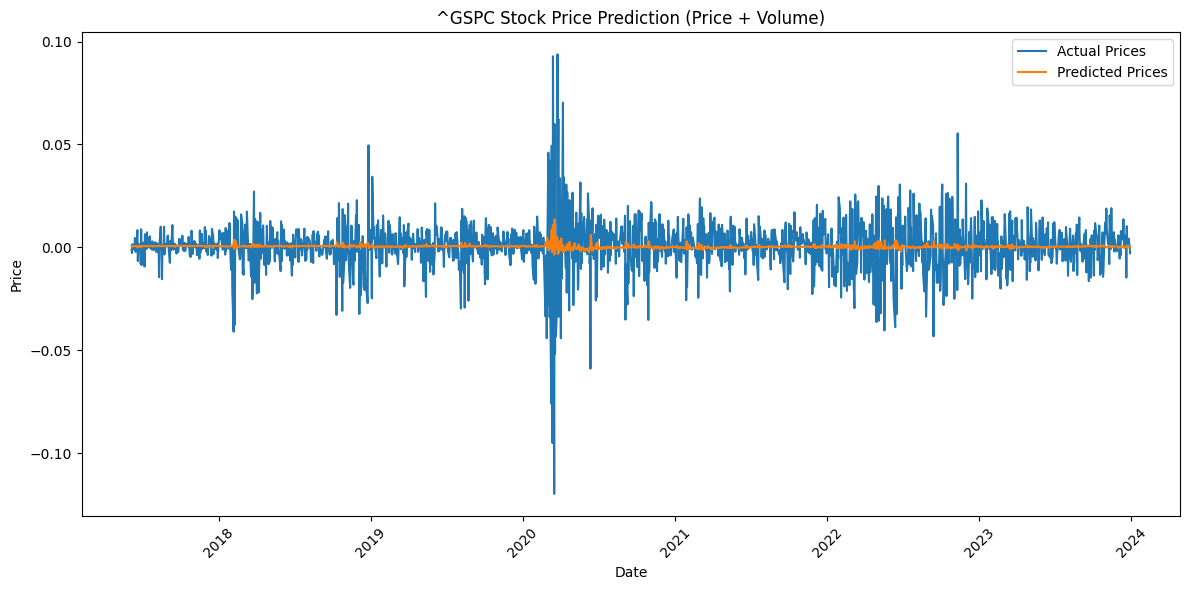

In [54]:
# Plotting the predicted pct changes vs the actual pct changes

plt.figure(figsize=(12,6))
plt.plot(dates[-len(actual_values):], actual_values, label='Actual Prices')
plt.plot(dates[-len(actual_values):], test_predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Stock Price Prediction (Price + Volume)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [55]:
def predict_future_prices(model, input_sequence, future_steps, scaler):
    model.eval()
    predictions = []
    input_seq = input_sequence.clone().detach()

    for _ in range(future_steps):
        with torch.no_grad():
            pred = model(input_seq.unsqueeze(0))  # Predict the next price
        predictions.append(pred.item())

        # Create a tensor with the predicted price and placeholders for the other features
        # The number of features should match the original input sequence
        pred_full = torch.zeros_like(input_seq[0]).to(device)  # Create a tensor of zeros with the same shape as a single time step
        pred_full[0] = pred.item()  # Set the predicted price in the first position

        # Update the input sequence by removing the first time step and adding the new prediction
        input_seq = torch.cat((input_seq[1:], pred_full.unsqueeze(0)))  # Append the new time step with the prediction

    # Inverse transform to get actual prices
    predictions = scaler.inverse_transform(np.column_stack((np.array(predictions), np.zeros((len(predictions), input_seq.size(1) - 1)))))[:, 0]
    
    return predictions


Future Predictions:
Day 1: $0.0005
Day 2: $-0.0004
Day 3: $-0.0004
Day 4: $-0.0004
Day 5: $-0.0004


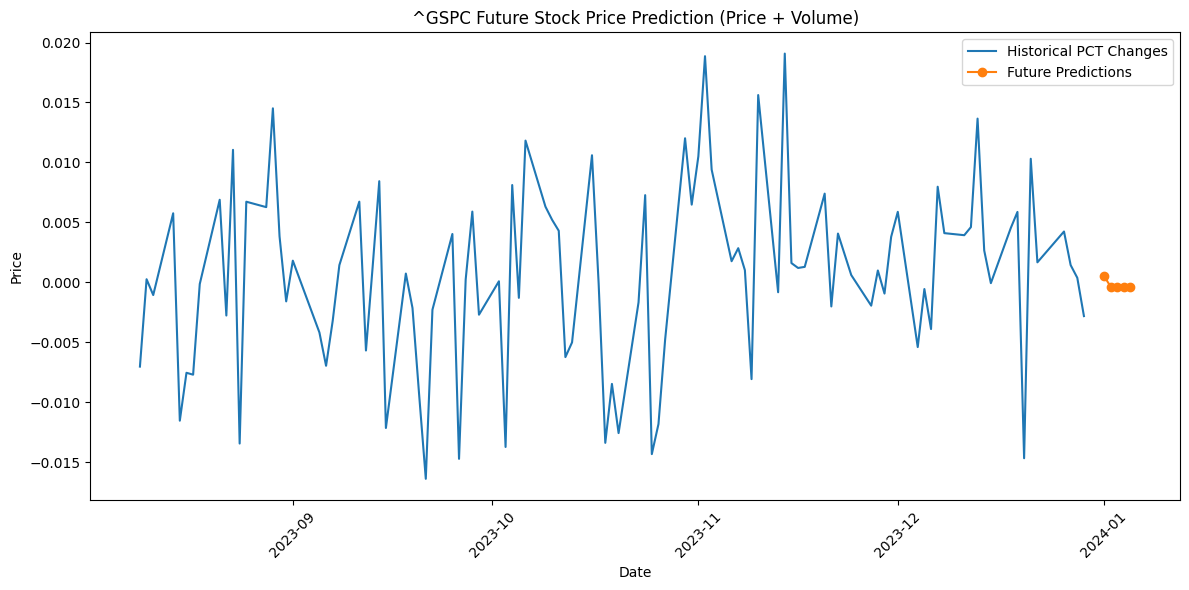

In [56]:
# Predict the next 5 days
future_steps = 5
last_input_sequence = test_inputs[-1]
future_predictions = predict_future_prices(model, last_input_sequence, future_steps, scaler)

print("Future Predictions:")
for i, pct in enumerate(future_predictions, 1):
    print(f"Day {i}: ${pct:.4f}")

# Create dates for future predictions
last_date = dates[-1]
future_dates = pd.date_range(last_date, periods=future_steps + 1, freq='B')[1:]  # 'B' for business day

plt.figure(figsize=(12,6))
plt.plot(dates[-100:], prices[-100:], label='Historical PCT Changes')
plt.plot(future_dates, future_predictions, label='Future Predictions', marker='o')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Future Stock Price Prediction (Price + Volume)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()